<h1>Evaluacion del Modelo BERT + FINE TUNNING</h1>

En el notebook <i>BERT_fine_tining.ipynb</i> realizamos el ajuste de este modelo para que resolviera el problema de clasificacion multiclase del reto que tenemos, ahora debemos evaluarlo.

In [ ]:
## Descomentar si esta trabajando en Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from transformers import AutoTokenizer, BertModel
import numpy as np
import torch.nn as nn

# Definimos aquí la misma clase que usaste en entrenamiento 

class BertForMultiLabel(nn.Module):
    def __init__(self, model_name: str, num_labels: int, dropout_prob: float = 0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            return_dict=True)
        pooled = outputs.pooler_output
        x = self.dropout(pooled)
        logits = self.classifier(x)
        return logits

# Ruta del modelo
output_dir = "/content/drive/MyDrive/techespere/bert_multilabel_model"
#output_dir = "models/bert_multilabel_model" ## Descomentar si se trabaja en local
state_path = f"{output_dir}/model_state.pth"

# Device (usar GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Carga del tokenizer
tokenizer = AutoTokenizer.from_pretrained(output_dir)

# Carga del checkpoint
ckpt = torch.load(state_path, map_location=device)  # map_location maneja CPU/GPU automáticamente
config = ckpt.get("config", {})
model_name = config.get("model_name", "bert-base-uncased")
num_labels = config.get("num_labels", 4)

# Instanciar modelo y cargar pesos
model = BertForMultiLabel(model_name=model_name, num_labels=num_labels)
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()

print("Modelo y tokenizer cargados correctamente.")

Device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Modelo y tokenizer cargados correctamente.


Nuevamente cargamos el dataset, en este caso creamos una funcion que se encargara de hacer la prediccion de los textos, de este modo la evaluacion se puede hacer mas efectiva.

In [14]:
from torch.utils.data import DataLoader

def predict_texts(model, tokenizer, texts, device, max_length=128, threshold=0.5):
    model.eval()
    enc = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    token_type_ids = enc.get("token_type_ids")
    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        probs = torch.sigmoid(logits).cpu().numpy()   # shape (n_texts, num_labels)
        preds = (probs >= threshold).astype(int)
    return probs, preds

# Ejemplo de uso:
texts = ["This is a test sentence.", "Another sample text to classify."]
probs, preds = predict_texts(model, tokenizer, texts, device, max_length=128, threshold=0.5)
print("Probabilidades:\n", probs)
print("Predicciones (binary):\n", preds)

Probabilidades:
 [[0.18593067 0.8039122  0.31287816 0.06447028]
 [0.30795282 0.6924851  0.27417547 0.09687209]]
Predicciones (binary):
 [[0 1 0 0]
 [0 1 0 0]]


In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

df = pd.read_csv("/content/drive/MyDrive/techespere/dataset.csv", sep=";")
#df = pd.read_csv("../data/dataset.csv", sep=";") ## Descomentar si se trabaja en local
df["text"] = (df["title"].fillna("") + " " + df["abstract"].fillna("")).str.strip()

X = df["text"].values
y = df["group"].values

# Define el orden fijo de las clases (columnas):
CLASSES = ['cardiovascular', 'neurological', 'hepatorenal', 'oncological']

# Parseo simple: split por '|'
y_lists = [s.split('|') if isinstance(s, str) and s else [] for s in y]

mlb = MultiLabelBinarizer(classes=CLASSES)
y = mlb.fit_transform(y_lists)  # shape: (n_samples, 4)

# Opcional: verificar orden
print("Orden de columnas:", mlb.classes_)  # ['cardiovascular','neurological','hepatorenal','oncological']

Orden de columnas: ['cardiovascular' 'neurological' 'hepatorenal' 'oncological']


In [8]:
X.shape, y.shape

((3565,), (3565, 4))

En este caso, solamente usaremos el 10% del dataset destinado a test para as pruebas del mismo.

In [ ]:
from sklearn.model_selection import train_test_split

# División en 90% train y 10% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,        # 10% para test
    random_state=42,      # semilla reproducible
    stratify=y           # asegura misma proporción de clases en train y test
)

In [ ]:
from sklearn.metrics import f1_score

# 1. Predecir sobre el conjunto de prueba
y_preds = predict_texts(model, tokenizer, X_test.tolist(), device, max_length=128, threshold=0.5)[1]

# 2. Pasar de probabilidades a clases
y_pred = np.argmax(y_preds, axis=1)
y_true = np.argmax(y_test, axis=1)

# 3. Calcular F1-score
f1_macro = f1_score(y_true, y_pred, average="macro")   # Promedio por clase
f1_micro = f1_score(y_true, y_pred, average="micro")   # Promedio global
f1_weighted = f1_score(y_true, y_pred, average="weighted") # Balanceado por soporte

print("F1-macro:", f1_macro)
print("F1-micro:", f1_micro)
print("F1-weighted:", f1_weighted)

F1-macro: 0.8881917372046468
F1-micro: 0.9187675070028011
F1-weighted: 0.919928619180211


El F1 - Scrore Weigthed en esta preba dió un valor del 91%, una calificacion excelente para el modelo.

In [16]:
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix

Evaluamos las matrices de confusion POR CLASE, de esta manera podemos garantizar que las predicciones por clase estan bien realizadas, sin fijarnos en las demás clases debido a que es un problema Multiclase.

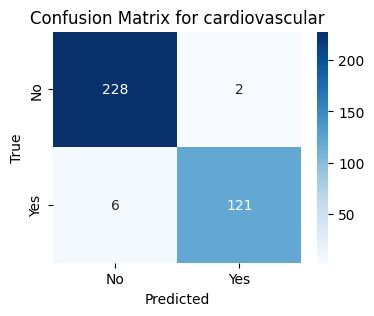

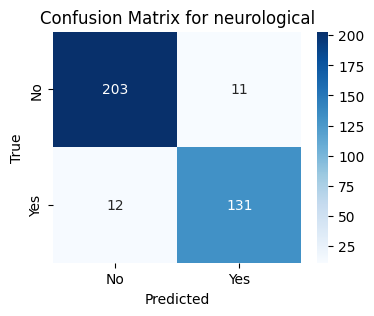

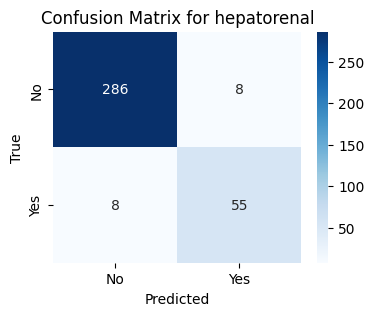

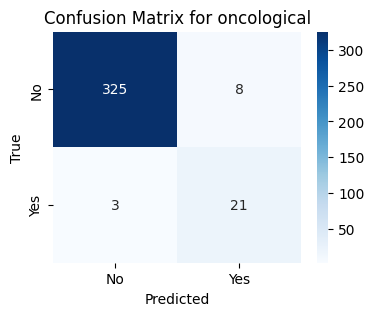

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

mcm = multilabel_confusion_matrix(y_true, y_pred)
all_labels = ['cardiovascular', 'neurological' ,'hepatorenal' ,'oncological']

for i, label in enumerate(all_labels):
    cm = mcm[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for {label}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

Las matrices de confusion muestran un rendimiento excelente en este caso, pues si vemos los falsos positivos o los falsos negativos, son un porcentaje muy pequeño del total de predicciones por cada clase.

In [25]:
# Accuracy exacta (exact match / subset accuracy): proporción de muestras donde todas las etiquetas coinciden
subset_accuracy = np.mean(np.all(y_preds == y_test, axis=1))

print(f"Subset accuracy (exact match): {subset_accuracy:.4f} ({subset_accuracy*100:.2f}%)")

Subset accuracy (exact match): 0.8263 (82.63%)


Con un accuracy del 82,63% podemos concluir que este es un modelo ideal para ser desplegado en el pipeline a produccion

In [30]:
y_preds[39], y_test[39]

(array([1, 0, 1, 0]), array([1, 0, 1, 0]))